In [123]:
# Librerias 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [124]:
# Leer archivo

bankT = pd.read_csv('bank_transactions.csv')

In [125]:
# Head

bankT.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


In [126]:
# Drop de valores null
bankT = bankT.dropna()

# Verificar que ya no hay valores null
if not bankT.isnull().values.any():
    print("Valores nulos:", bankT.isnull().values.any())

Valores nulos: False


In [127]:
# Drop de valores duplicados
bankT = bankT.drop_duplicates()

if not bankT.duplicated().values.any():
    print("Valores duplicados:", bankT.duplicated().values.any())

Valores duplicados: False


In [128]:
# Pasar a numerico

bankT['CustGender'] = bankT['CustGender'].replace(['M','F'],[0,1])
bankT = bankT[bankT['CustGender'] != 'T']

In [129]:
# Eliminar customerID

bankT = bankT.drop(['CustomerID'], axis=1)

In [130]:
# Elminar TransactionID

bankT = bankT.drop(['TransactionID'], axis=1)

In [131]:
# Convert TransactionDate to datetime format
bankT['TransactionDate'] = pd.to_datetime(bankT['TransactionDate'])
bankT['TransactionYear'] = bankT['TransactionDate'].dt.year
bankT = bankT.drop(['TransactionDate'], axis=1)

In [132]:
# Pasar fecha año de nacimiento a valor numerico
bankT['BirthYear'] = pd.to_numeric(bankT['CustomerDOB'].str[-2:], errors='coerce')
bankT['BirthYear'] += 1900

bankT = bankT.drop(['CustomerDOB'], axis=1)

In [133]:
bankT = bankT.drop(['CustLocation'], axis=1)

In [134]:
# Escalar datos
from sklearn.preprocessing import StandardScaler, normalize

Escalador = StandardScaler()
Escalar = Escalador.fit_transform(bankT)
Normalizado = normalize(Escalar)
bankT = pd.DataFrame(Normalizado, columns=bankT.columns) 

In [135]:
bankT.head()

,CustGender,CustAccountBalance,TransactionTime,TransactionAmount (INR),TransactionYear,BirthYear
0,0.909976,-0.063420,-0.150001,-0.129790,0.0,0.358575
1,-0.143454,-0.031448,-0.070338,0.951649,0.0,-0.260479
2,0.895007,-0.062342,-0.152781,-0.091704,0.0,0.404135
3,0.855716,0.461196,-0.146054,0.039119,0.0,-0.179406
4,0.938023,-0.072845,0.267063,0.017054,0.0,0.207830


In [136]:

# Grafico de barras
sns.countplot(x='CustGender', data=bankT)

<AxesSubplot: >

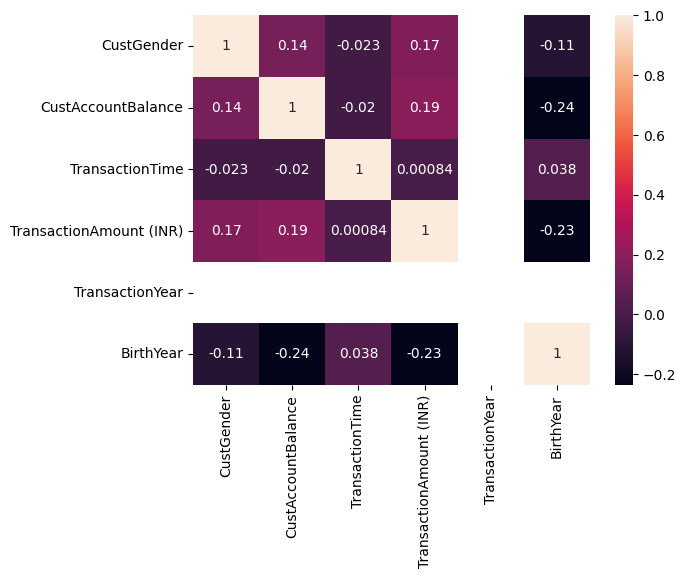

In [137]:
# Grafico exploratorio
sns.heatmap(bankT.corr(), annot=True)

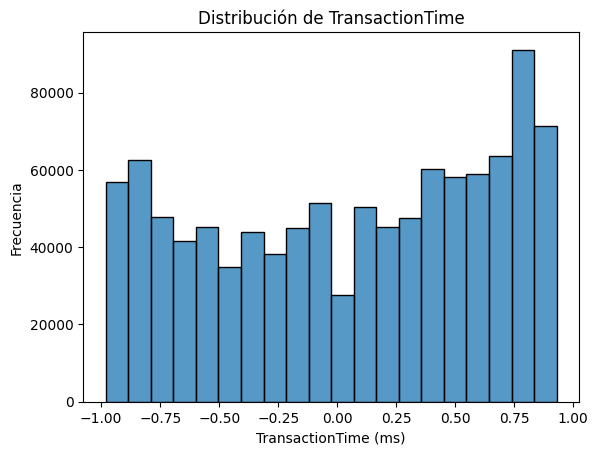

In [138]:
sns.histplot(data=bankT, x="TransactionTime", bins=20)
plt.xlabel("TransactionTime (ms)")
plt.ylabel("Frecuencia")
plt.title("Distribución de TransactionTime")
plt.show()

<AxesSubplot: xlabel='CustAccountBalance', ylabel='TransactionAmount (INR)'>

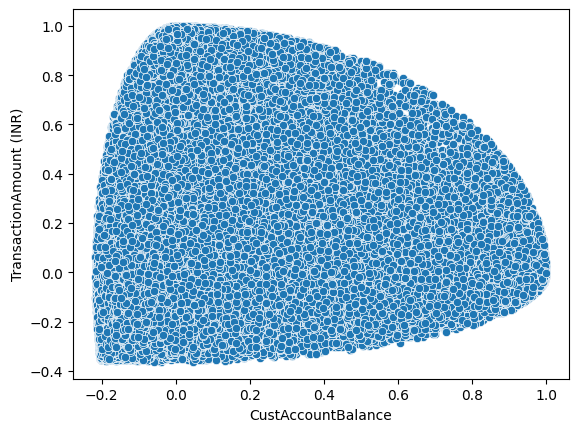

In [139]:
# Gráfico exploratorio para ver relación entre balance monetario y valor de transacciones
sns.scatterplot(data=bankT, x="CustAccountBalance", y="TransactionAmount (INR)")

#### 1.1 Implementación sin librería

In [180]:
class GMM:

    def __init__(self, n_components, n_iters, tol):
        self.n_components = n_components
        self.n_iters = n_iters
        self.tol = tol

    def fit(self, X):

        # Dimensión de la data y vector
        n_row, n_col = X.shape     
        self.resp = np.zeros((n_row, self.n_components))

        # Inicialización de parametros
        np.random.seed(42)
        chosen = np.random.choice(n_row, self.n_components, replace = False)
        self.means = X[chosen]
        self.weights = np.full(self.n_components, 1 / self.n_components)
        
        #Observación de dicha columna
        shape = self.n_components, n_col, n_col
        self.covs = np.full(shape, np.cov(X, rowvar = False))

        log_likelihood = 0
        self.converged = False
        self.log_likelihood_trace = []      

        for i in range(self.n_iters):
            log_likelihood_new = self.estep(X)
            self.mstep(X)

            if abs(log_likelihood_new - log_likelihood) <= self.tol:
                self.converged = True
                break
  
            log_likelihood = log_likelihood_new
            self.log_likelihood_trace.append(log_likelihood)

        return self

    def estep(self, X):
        #Paso de Expectation
        self._compute_log_likelihood(X)
        log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))

        # Normalización de clusters
        self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
        return log_likelihood

    def _compute_log_likelihood(self, X):
        #Calculo de log likelihod
        for k in range(self.n_components):
            prior = self.weights[k]
            # Uso de la normal multivariate
            likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
            self.resp[:, k] = prior * likelihood

        return self

    def mstep(self, X):
        # Paso de maximimization
        # Responsabilidad de cada clustesr
        resp_weights = self.resp.sum(axis = 0)
        
        # Pesos
        self.weights = resp_weights / X.shape[0]

        # Medias
        weighted_sum = np.dot(self.resp.T, X)
        self.means = weighted_sum / resp_weights.reshape(-1, 1)
        # Covariancia
        for k in range(self.n_components):
            diff = (X - self.means[k]).T
            weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
            self.covs[k] = weighted_sum / resp_weights[k]
            
        return self


In [178]:
def plot_contours(data, means, covs, title):
    #Visalización de datos
    col = ['green', 'red', 'indigo']
    plt.figure()
    u_labels = list(np.unique(classes))
    for i in u_labels:
        plt.scatter(data[classes == i, 0], data[classes == i, 1], s = 20, label = i)

    delta = 0.025
    k = means.shape[0]
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['green', 'red', 'indigo']
    #Formación de las elipse
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])
    plt.xlim(-.4,1.2)
    plt.ylim(-.4,1.2)
    plt.title(title)
    plt.tight_layout()

converged iteration: 30


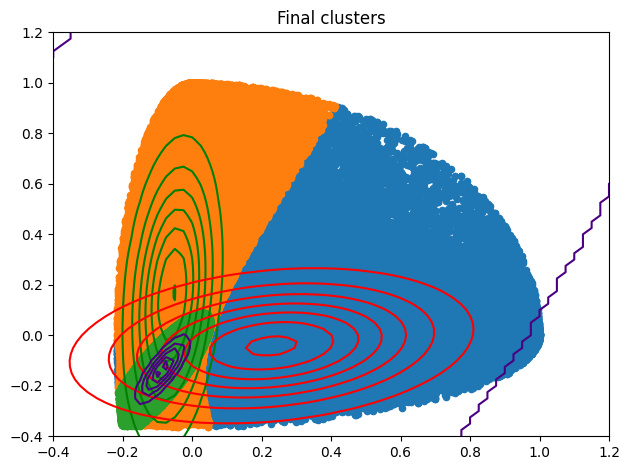

In [179]:
x = bankT[["CustAccountBalance", "TransactionAmount (INR)"]]
gmm = GMM(n_components = 3, n_iters = 30, tol = 1e-4, seed = 4)
gmm.fit(x.to_numpy())

print('Iteración de convergencia:', len(gmm.log_likelihood_trace))
plot_contours(x.to_numpy(), gmm.means, gmm.covs, 'Final clusters')



#### 1.2 Implementación con librería

In [143]:
# Librerías
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA


In [144]:
PCALibreria = PCA(n_components=2)
X = PCALibreria.fit_transform(bankT)
X = pd.DataFrame(X)
X.columns = ['PC1', 'PC2']

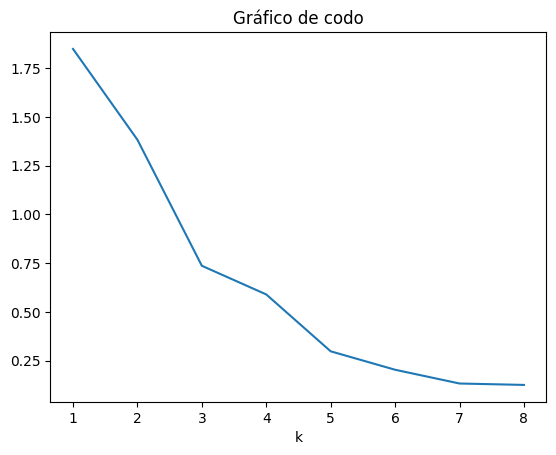

In [145]:
def NLLFunc(X, kmax=10):
    nll = [-GaussianMixture(n_components=k).fit(X).score(X) for k in range(1, kmax+1)]
    return nll
nll = NLLFunc(X, kmax=8)

sns.lineplot(x=range(1, 9), y=nll)
plt.xlabel("k")
plt.title("Gráfico de codo")
plt.show()

In [146]:
GaussianMixture(n_components=4).fit(X).score(X)

-0.45052421499128015

In [147]:
# Métrica de desempeño
print("Log likelihood:", -GaussianMixture(n_components=4).fit(X).score(X))

Log likelihood: 0.5895706154478534


#### Referencia: 
https://github.com/Magho/Fitting-Gaussian-Mixture-Models-with-EM/blob/master/3_em-for-gmm_gl.ipynb.ipynb